In [21]:
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
from tensorflow import keras
import IPython.display as ipd
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
%matplotlib inline

In [22]:
from tensorflow import keras
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [46]:
root_path="C:/Users/sarib/Desktop/Gohm/SpeechRecognition/database"

In [47]:
allpaths=[]
for root, directories, files in os.walk(root_path):
    for file_names in files:
        if root is not root_path:
            allpaths.append(os.path.join(root,file_names))

In [48]:
dataframe= pd.DataFrame(allpaths, columns=["paths"])
np.random.shuffle(dataframe.values)

In [49]:
train_data = dataframe[:21188]
valid_data = dataframe[21188:23836:]
test_data= dataframe[23836:]

In [50]:
train_paths=np.array(train_data['paths'].tolist())
valid_paths=np.array(valid_data['paths'].tolist())
test_paths=np.array(test_data['paths'].tolist())

In [57]:
class prefit(tf.keras.utils.Sequence):
    worddict = {
            "ac": 0,
            "asagi": 1,
            "baslat": 2,
            "devam": 3,
            "dur": 4,
            "evet": 5,
            "geri":6,
            "hayir": 7,
            "ileri": 8,
            "iptal": 9,
            "kapa":10,
            "sag":11,
            "sol": 12,
            "yukari":13

            }

    def __init__(self, path):
        self.shuffle=True
        self.paths=path
        
    def __mfcc_extractor(self,file):
        signal, sample_rate = librosa.load(file)
        ipd.Audio(file)
        mfccs_features = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40)
        mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
        
        return mfccs_scaled_features

    def __getitem__(self, index):
        data = self.__mfcc_extractor(self.paths[index])/10
        labelY=os.path.basename(os.path.dirname(self.paths[index]))
        extracted_feataures=[]
        extracted_feataures.append([data,labelY])
        extracted_feataures_dataframe= pd.DataFrame(extracted_feataures, columns=["melspectrogram", "word"])
        X=np.array(extracted_feataures_dataframe['melspectrogram'].tolist())
        y = np.empty((0,14), dtype=int)
        y_class = keras.utils.to_categorical(self.worddict[labelY], num_classes=14) #TODO: worde göre yapılacak
        y_data = []
        y_data.append(y_class)
        y = np.concatenate((y, np.array(y_data)))
        return X, y


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.paths)


    def __len__(self):
        return len(self.paths)
        #pass

In [58]:
train_prefit = prefit(path=train_paths)
valid_prefit = prefit(path=valid_paths)
test_prefit= prefit(path=test_paths)

In [227]:
train_prefit

X:  (1, 40) y:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


(array([[-4.8303381e+02,  6.2193104e+01, -1.0424236e+01,  1.7892550e+01,
         -1.6628336e+01,  6.8580014e-01, -2.7435713e+00, -5.7047033e+00,
         -3.4347045e+00,  2.6712301e+00,  2.5144095e+00, -1.0999187e+01,
         -1.5599624e+00, -9.3215141e+00, -7.0484557e+00, -8.8117450e-01,
         -2.5051367e+00,  2.2852225e+00, -1.1657153e+00, -7.5033289e-01,
         -1.5244908e+00, -4.9222836e+00, -7.7779412e-01,  8.2982373e-01,
         -5.5398746e+00, -1.1497967e+00,  4.5375552e+00, -1.0562915e+00,
          7.4132216e-01,  3.2517126e+00, -1.2010108e+00, -1.4040219e+00,
         -2.3793812e-01, -2.0607519e+00, -3.4266241e+00, -3.2657182e+00,
         -3.3512824e+00, -1.8446364e+00,  2.2689734e+00,  2.0459657e+00]],
       dtype=float32),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [26]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [59]:
def create_model():
    model= Sequential()

    model.add(Flatten(input_shape=(40, )))
    model.add(Dense(300, Activation('relu')))
    model.add(Dropout(0.2))
    model.add(Dense(300, Activation('relu')))
    model.add(Dense(14, Activation('softmax')))
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=Adam())
    return model

In [60]:
model=create_model()

In [61]:
checkpointpath="checkpoint/cp.ckpt"
checkpointer = ModelCheckpoint(checkpointpath, monitor='val_accuracy',
                               verbose=2, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=2)
callbackList= [checkpointer, early_stop]
history=model.fit(train_prefit, validation_data=valid_prefit, epochs=200, callbacks=callbackList, steps_per_epoch=662, verbose=1)

Epoch 1/200
661/662 [============================>.] - ETA: 0s - loss: 3.0556 - accuracy: 0.1135
Epoch 1: val_accuracy improved from -inf to 0.20468, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 124s 187ms/step - loss: 3.0557 - accuracy: 0.1133 - val_loss: 2.3568 - val_accuracy: 0.2047
Epoch 2/200
662/662 [==============================] - ETA: 0s - loss: 2.2627 - accuracy: 0.2251
Epoch 2: val_accuracy improved from 0.20468 to 0.25566, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 135s 204ms/step - loss: 2.2627 - accuracy: 0.2251 - val_loss: 2.0875 - val_accuracy: 0.2557
Epoch 3/200
662/662 [==============================] - ETA: 0s - loss: 2.0790 - accuracy: 0.2704
Epoch 3: val_accuracy improved from 0.25566 to 0.31722, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 126s 190ms/step - loss: 2.0790 - accuracy: 0.2704 - val_loss: 1.9701 - val_accuracy: 0.3172
Epoch 4/200
662/662 [==============================] - ETA: 0s - loss: 1.9710 - accuracy: 0.3202
Epoch 4: val_accuracy improved from 0.31722 to 0.36971, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 123s 186ms/step - loss: 1.9710 - accuracy: 0.3202 - val_loss: 1.8495 - val_accuracy: 0.3697
Epoch 5/200
661/662 [============================>.] - ETA: 0s - loss: 1.9153 - accuracy: 0.3495
Epoch 5: val_accuracy did not improve from 0.36971
662/662 [==============================] - 120s 182ms/step - loss: 1.9159 - accuracy: 0.3489 - val_loss: 1.8394 - val_accuracy: 0.3656
Epoch 6/200
662/662 [==============================] - ETA: 0s - loss: 1.8675 - accuracy: 0.3716
Epoch 6: val_accuracy did not improve from 0.36971
662/662 [==============================] - 117s 178ms/step - loss: 1.8675 - accuracy: 0.3716 - val_loss: 1.8510 - val_accuracy: 0.3240
Epoch 7/200
662/662 [==============================] - ETA: 0s - loss: 1.8490 - accuracy: 0.3656
Epoch 7: val_accuracy improved from 0.36971 to 0.39162, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 116s 175ms/step - loss: 1.8490 - accuracy: 0.3656 - val_loss: 1.7219 - val_accuracy: 0.3916
Epoch 8/200
662/662 [==============================] - ETA: 0s - loss: 1.8863 - accuracy: 0.3550
Epoch 8: val_accuracy improved from 0.39162 to 0.41767, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 122s 185ms/step - loss: 1.8863 - accuracy: 0.3550 - val_loss: 1.7098 - val_accuracy: 0.4177
Epoch 9/200
662/662 [==============================] - ETA: 0s - loss: 1.8294 - accuracy: 0.3580
Epoch 9: val_accuracy did not improve from 0.41767
662/662 [==============================] - 116s 175ms/step - loss: 1.8294 - accuracy: 0.3580 - val_loss: 1.7232 - val_accuracy: 0.4101
Epoch 10/200
661/662 [============================>.] - ETA: 0s - loss: 1.8408 - accuracy: 0.3616
Epoch 10: val_accuracy did not improve from 0.41767
662/662 [==============================] - 123s 186ms/step - loss: 1.8401 - accuracy: 0.3625 - val_loss: 1.7258 - val_accuracy: 0.4018
Epoch 11/200
661/662 [============================>.] - ETA: 0s - loss: 1.7920 - accuracy: 0.3661
Epoch 11: val_accuracy improved from 0.41767 to 0.42145, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 121s 182ms/step - loss: 1.7898 - accuracy: 0.3671 - val_loss: 1.6537 - val_accuracy: 0.4215
Epoch 12/200
661/662 [============================>.] - ETA: 0s - loss: 1.6898 - accuracy: 0.4327
Epoch 12: val_accuracy did not improve from 0.42145
662/662 [==============================] - 115s 174ms/step - loss: 1.6923 - accuracy: 0.4320 - val_loss: 1.6922 - val_accuracy: 0.4192
Epoch 13/200
662/662 [==============================] - ETA: 0s - loss: 1.7274 - accuracy: 0.4124
Epoch 13: val_accuracy improved from 0.42145 to 0.44184, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 113s 171ms/step - loss: 1.7274 - accuracy: 0.4124 - val_loss: 1.6247 - val_accuracy: 0.4418
Epoch 14/200
662/662 [==============================] - ETA: 0s - loss: 1.7707 - accuracy: 0.4033
Epoch 14: val_accuracy did not improve from 0.44184
662/662 [==============================] - 115s 175ms/step - loss: 1.7707 - accuracy: 0.4033 - val_loss: 1.6624 - val_accuracy: 0.4199
Epoch 15/200
662/662 [==============================] - ETA: 0s - loss: 1.6351 - accuracy: 0.4215
Epoch 15: val_accuracy did not improve from 0.44184
662/662 [==============================] - 115s 174ms/step - loss: 1.6351 - accuracy: 0.4215 - val_loss: 1.6282 - val_accuracy: 0.4384
Epoch 16/200
661/662 [============================>.] - ETA: 0s - loss: 1.6619 - accuracy: 0.4191
Epoch 16: val_accuracy did not improve from 0.44184
662/662 [==============================] - 120s 181ms/step - loss: 1.6629 - accuracy: 0.4184 - val_loss: 1.6412 - val_accuracy: 0.4158
Epoch 17/2

INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 118s 178ms/step - loss: 1.6234 - accuracy: 0.4517 - val_loss: 1.5620 - val_accuracy: 0.4452
Epoch 18/200
661/662 [============================>.] - ETA: 0s - loss: 1.7064 - accuracy: 0.4070
Epoch 18: val_accuracy did not improve from 0.44524
662/662 [==============================] - 124s 188ms/step - loss: 1.7044 - accuracy: 0.4079 - val_loss: 1.6808 - val_accuracy: 0.4237
Epoch 19/200
661/662 [============================>.] - ETA: 0s - loss: 1.6857 - accuracy: 0.3933
Epoch 19: val_accuracy improved from 0.44524 to 0.44637, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 121s 183ms/step - loss: 1.6840 - accuracy: 0.3943 - val_loss: 1.6006 - val_accuracy: 0.4464
Epoch 20/200
662/662 [==============================] - ETA: 0s - loss: 1.6378 - accuracy: 0.4441
Epoch 20: val_accuracy improved from 0.44637 to 0.46261, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 124s 187ms/step - loss: 1.6378 - accuracy: 0.4441 - val_loss: 1.5429 - val_accuracy: 0.4626
Epoch 21/200
662/662 [==============================] - ETA: 0s - loss: 1.5726 - accuracy: 0.4834
Epoch 21: val_accuracy did not improve from 0.46261
662/662 [==============================] - 127s 192ms/step - loss: 1.5726 - accuracy: 0.4834 - val_loss: 1.5866 - val_accuracy: 0.4373
Epoch 22/200
661/662 [============================>.] - ETA: 0s - loss: 1.6870 - accuracy: 0.4054
Epoch 22: val_accuracy did not improve from 0.46261
662/662 [==============================] - 123s 186ms/step - loss: 1.6883 - accuracy: 0.4048 - val_loss: 1.5468 - val_accuracy: 0.4554
Epoch 23/200
662/662 [==============================] - ETA: 0s - loss: 1.5409 - accuracy: 0.4471
Epoch 23: val_accuracy improved from 0.46261 to 0.47054, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 120s 181ms/step - loss: 1.5409 - accuracy: 0.4471 - val_loss: 1.4975 - val_accuracy: 0.4705
Epoch 24/200
661/662 [============================>.] - ETA: 0s - loss: 1.5458 - accuracy: 0.4690
Epoch 24: val_accuracy did not improve from 0.47054
662/662 [==============================] - 118s 179ms/step - loss: 1.5483 - accuracy: 0.4683 - val_loss: 1.5967 - val_accuracy: 0.4464
Epoch 25/200
662/662 [==============================] - ETA: 0s - loss: 1.6549 - accuracy: 0.4245
Epoch 25: val_accuracy did not improve from 0.47054
662/662 [==============================] - 120s 181ms/step - loss: 1.6549 - accuracy: 0.4245 - val_loss: 1.5916 - val_accuracy: 0.4468
Epoch 26/200
661/662 [============================>.] - ETA: 0s - loss: 1.6141 - accuracy: 0.4644
Epoch 26: val_accuracy improved from 0.47054 to 0.47281, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 121s 183ms/step - loss: 1.6174 - accuracy: 0.4637 - val_loss: 1.5006 - val_accuracy: 0.4728
Epoch 27/200
662/662 [==============================] - ETA: 0s - loss: 1.5750 - accuracy: 0.4456
Epoch 27: val_accuracy improved from 0.47281 to 0.48150, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 122s 184ms/step - loss: 1.5750 - accuracy: 0.4456 - val_loss: 1.4952 - val_accuracy: 0.4815
Epoch 28/200
661/662 [============================>.] - ETA: 0s - loss: 1.5572 - accuracy: 0.4644
Epoch 28: val_accuracy did not improve from 0.48150
662/662 [==============================] - 122s 184ms/step - loss: 1.5565 - accuracy: 0.4637 - val_loss: 1.5443 - val_accuracy: 0.4569
Epoch 29/200
661/662 [============================>.] - ETA: 0s - loss: 1.5918 - accuracy: 0.4402
Epoch 29: val_accuracy improved from 0.48150 to 0.50378, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 120s 182ms/step - loss: 1.5898 - accuracy: 0.4411 - val_loss: 1.4444 - val_accuracy: 0.5038
Epoch 30/200
661/662 [============================>.] - ETA: 0s - loss: 1.6212 - accuracy: 0.4357
Epoch 30: val_accuracy did not improve from 0.50378
662/662 [==============================] - 121s 184ms/step - loss: 1.6199 - accuracy: 0.4366 - val_loss: 1.5464 - val_accuracy: 0.4615
Epoch 31/200
661/662 [============================>.] - ETA: 0s - loss: 1.6192 - accuracy: 0.4629
Epoch 31: val_accuracy did not improve from 0.50378
662/662 [==============================] - 120s 182ms/step - loss: 1.6174 - accuracy: 0.4637 - val_loss: 1.4386 - val_accuracy: 0.4974
Epoch 32/200
662/662 [==============================] - ETA: 0s - loss: 1.6408 - accuracy: 0.4366
Epoch 32: val_accuracy did not improve from 0.50378
662/662 [==============================] - 122s 185ms/step - loss: 1.6408 - accuracy: 0.4366 - val_loss: 1.5535 - val_accuracy: 0.4547
Epoch 33/2

INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 114s 172ms/step - loss: 1.4856 - accuracy: 0.4819 - val_loss: 1.4127 - val_accuracy: 0.5079
Epoch 50/200
662/662 [==============================] - ETA: 0s - loss: 1.5096 - accuracy: 0.4804
Epoch 50: val_accuracy improved from 0.50793 to 0.52644, saving model to checkpoint\cp.ckpt


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 115s 174ms/step - loss: 1.5096 - accuracy: 0.4804 - val_loss: 1.3734 - val_accuracy: 0.5264
Epoch 51/200
661/662 [============================>.] - ETA: 0s - loss: 1.4966 - accuracy: 0.4826
Epoch 51: val_accuracy did not improve from 0.52644
662/662 [==============================] - 115s 173ms/step - loss: 1.4947 - accuracy: 0.4834 - val_loss: 1.4327 - val_accuracy: 0.4868
Epoch 52/200
662/662 [==============================] - ETA: 0s - loss: 1.4995 - accuracy: 0.4864
Epoch 52: val_accuracy did not improve from 0.52644
662/662 [==============================] - 112s 169ms/step - loss: 1.4995 - accuracy: 0.4864 - val_loss: 1.3848 - val_accuracy: 0.5091
Epoch 53/200
661/662 [============================>.] - ETA: 0s - loss: 1.4170 - accuracy: 0.5053
Epoch 53: val_accuracy did not improve from 0.52644
662/662 [==============================] - 113s 170ms/step - loss: 1.4154 - accuracy: 0.5060 - val_loss: 1.4185 - val_accuracy: 0.5019
Epoch 54/2

INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 115s 174ms/step - loss: 1.3787 - accuracy: 0.5166 - val_loss: 1.3591 - val_accuracy: 0.5313
Epoch 62/200
662/662 [==============================] - ETA: 0s - loss: 1.4744 - accuracy: 0.5015
Epoch 62: val_accuracy did not improve from 0.53134
662/662 [==============================] - 113s 171ms/step - loss: 1.4744 - accuracy: 0.5015 - val_loss: 1.4135 - val_accuracy: 0.5015
Epoch 63/200
662/662 [==============================] - ETA: 0s - loss: 1.4866 - accuracy: 0.4970
Epoch 63: val_accuracy did not improve from 0.53134
662/662 [==============================] - 111s 167ms/step - loss: 1.4866 - accuracy: 0.4970 - val_loss: 1.3593 - val_accuracy: 0.5177
Epoch 64/200
662/662 [==============================] - ETA: 0s - loss: 1.5208 - accuracy: 0.4713
Epoch 64: val_accuracy did not improve from 0.53134
662/662 [==============================] - 113s 171ms/step - loss: 1.5208 - accuracy: 0.4713 - val_loss: 1.4685 - val_accuracy: 0.4909
Epoch 65/2

INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 114s 172ms/step - loss: 1.4523 - accuracy: 0.5076 - val_loss: 1.3298 - val_accuracy: 0.5412
Epoch 76/200
662/662 [==============================] - ETA: 0s - loss: 1.5628 - accuracy: 0.4532
Epoch 76: val_accuracy did not improve from 0.54116
662/662 [==============================] - 122s 184ms/step - loss: 1.5628 - accuracy: 0.4532 - val_loss: 1.3516 - val_accuracy: 0.5245
Epoch 77/200
662/662 [==============================] - ETA: 0s - loss: 1.4200 - accuracy: 0.4879
Epoch 77: val_accuracy did not improve from 0.54116
662/662 [==============================] - 116s 175ms/step - loss: 1.4200 - accuracy: 0.4879 - val_loss: 1.3728 - val_accuracy: 0.5313
Epoch 78/200
661/662 [============================>.] - ETA: 0s - loss: 1.3886 - accuracy: 0.5083
Epoch 78: val_accuracy did not improve from 0.54116
662/662 [==============================] - 116s 175ms/step - loss: 1.3883 - accuracy: 0.5091 - val_loss: 1.3552 - val_accuracy: 0.5347
Epoch 79/2

INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 117s 176ms/step - loss: 1.4191 - accuracy: 0.5151 - val_loss: 1.3042 - val_accuracy: 0.5548
Epoch 81/200
662/662 [==============================] - ETA: 0s - loss: 1.4794 - accuracy: 0.5091
Epoch 81: val_accuracy did not improve from 0.55476
662/662 [==============================] - 120s 181ms/step - loss: 1.4794 - accuracy: 0.5091 - val_loss: 1.3052 - val_accuracy: 0.5344
Epoch 82/200
662/662 [==============================] - ETA: 0s - loss: 1.3894 - accuracy: 0.5483
Epoch 82: val_accuracy did not improve from 0.55476
662/662 [==============================] - 117s 176ms/step - loss: 1.3894 - accuracy: 0.5483 - val_loss: 1.2947 - val_accuracy: 0.5483
Epoch 83/200
662/662 [==============================] - ETA: 0s - loss: 1.3898 - accuracy: 0.5136
Epoch 83: val_accuracy did not improve from 0.55476
662/662 [==============================] - 115s 174ms/step - loss: 1.3898 - accuracy: 0.5136 - val_loss: 1.3579 - val_accuracy: 0.5366
Epoch 84/2

INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets


662/662 [==============================] - 118s 179ms/step - loss: 1.5187 - accuracy: 0.4773 - val_loss: 1.2923 - val_accuracy: 0.5555
Epoch 91/200
662/662 [==============================] - ETA: 0s - loss: 1.3694 - accuracy: 0.5257
Epoch 91: val_accuracy did not improve from 0.55551
662/662 [==============================] - 116s 175ms/step - loss: 1.3694 - accuracy: 0.5257 - val_loss: 1.3061 - val_accuracy: 0.5397
Epoch 92/200
661/662 [============================>.] - ETA: 0s - loss: 1.5069 - accuracy: 0.5159
Epoch 92: val_accuracy did not improve from 0.55551
662/662 [==============================] - 114s 172ms/step - loss: 1.5054 - accuracy: 0.5166 - val_loss: 1.3594 - val_accuracy: 0.5166
Epoch 93/200
662/662 [==============================] - ETA: 0s - loss: 1.3580 - accuracy: 0.5272
Epoch 93: val_accuracy did not improve from 0.55551
662/662 [==============================] - 114s 173ms/step - loss: 1.3580 - accuracy: 0.5272 - val_loss: 1.3145 - val_accuracy: 0.5427
Epoch 94/2

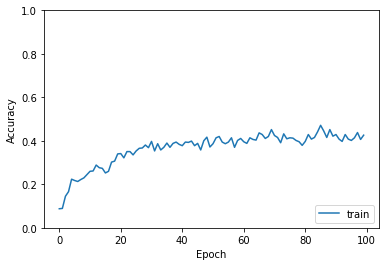

In [11]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [12]:
print("Test Score: ", model.evaluate(test_prefit))

NameError: name 'data' is not defined

In [23]:
model.load_weights(checkpointpath)

In [ ]:
print("Test Score: ", model.evaluate(test_prefit))

ADDING SECOND DATASET

In [ ]:
pt2=os.path.join(root_path,"dataset2")
data2 = prefit(path=pt2)

In [ ]:
history=model.fit(data2, epochs=10, verbose=2)

Epoch 1/10
10/10 - 4s - loss: 146.7196 - accuracy: 0.0000e+00 - 4s/epoch - 386ms/step
Epoch 2/10
10/10 - 5s - loss: 4.4903 - accuracy: 0.0000e+00 - 5s/epoch - 467ms/step
Epoch 3/10
10/10 - 4s - loss: 2.8922 - accuracy: 0.1374 - 4s/epoch - 444ms/step
Epoch 4/10
10/10 - 5s - loss: 2.6725 - accuracy: 0.0060 - 5s/epoch - 505ms/step
Epoch 5/10
10/10 - 5s - loss: 2.9794 - accuracy: 0.0959 - 5s/epoch - 549ms/step
Epoch 6/10
10/10 - 6s - loss: 2.7908 - accuracy: 0.0000e+00 - 6s/epoch - 591ms/step
Epoch 7/10
10/10 - 6s - loss: 2.6360 - accuracy: 0.0988 - 6s/epoch - 599ms/step
Epoch 8/10
10/10 - 6s - loss: 2.6354 - accuracy: 0.2022 - 6s/epoch - 643ms/step
Epoch 9/10
10/10 - 7s - loss: 2.6410 - accuracy: 0.0997 - 7s/epoch - 678ms/step
Epoch 10/10
10/10 - 7s - loss: 2.6389 - accuracy: 0.1009 - 7s/epoch - 690ms/step


In [ ]:
print("Test Score: ", model.evaluate(data))

10/10 [==============================] - 3s 238ms/step - loss: 2.6375 - accuracy: 0.0000e+00
Test Score:  [2.6375293731689453, 0.0]


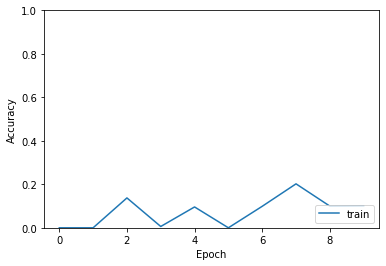

In [ ]:
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [32]:
inverse_worddict=dict((v, k) for k, v in prefit_data.worddict.items())

In [35]:
def mfcc_extractor(file):
    signal, sample_rate = librosa.load(file)
    ipd.Audio(file)
    mfccs_features = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

In [40]:
ac= mfcc_extractor('C:/Users/sarib/Desktop/Gohm/SpeechRecognition/database/asagi/asagi_AHCG_WFMOQIR.wav')
ac

array([-3.7937509e+02,  1.0185578e+02, -1.8799070e+01,  2.2251308e+01,
       -7.0540333e+00, -1.2938453e+01, -1.0100121e+01, -1.1337861e+01,
       -5.9151464e+00,  9.4830263e-01,  4.8738021e-01, -8.5327635e+00,
       -2.0648711e+00, -7.1784778e+00, -3.9210703e+00,  1.0371338e+00,
       -6.1326141e+00, -4.4220195e+00, -1.2640775e+01, -1.5805532e+01,
       -3.0032020e+00, -2.5017748e+00, -9.9128670e-01,  2.4950564e+00,
       -2.4508030e+00,  1.6640465e+00, -1.1013594e-02, -2.2699633e+00,
        2.2324312e+00, -2.0490513e+00, -4.1297235e+00, -5.9483304e+00,
       -9.7534809e+00, -6.2976561e+00, -1.6762021e+00, -9.3641275e-01,
        6.8987975e+00,  1.1467242e+01,  5.5930357e+00,  8.1722374e+00],
      dtype=float32)

In [37]:
predictiondata_feataures =[]
counter_true=0
for root, directories, files in os.walk("C:/Users/sarib/Desktop/Gohm/SpeechRecognition/RecordsFromDataset"): 
    for file_names in files:
        if root is not root_path:
            #print(os.path.join(root,file_names) )
            r = mfcc_extractor(os.path.join(root,file_names))
            rl=r.reshape(1,-1)
            #rl = r[np.newaxis, ...]
            predicted_label=tuple(np.argmax(model.predict(rl), axis=1))
            prediction_class = inverse_worddict[predicted_label[0]]
            predictiondata_feataures.append([os.path.basename(os.path.normpath(root)),prediction_class,predicted_label[0]])
            if os.path.basename(os.path.normpath(root))==prediction_class:
                counter_true+=1

In [38]:
predictiondata_feataures_dataframe= pd.DataFrame(predictiondata_feataures, columns=["actual data", "predicted data", "predicted label"])
percentage= (counter_true/len(predictiondata_feataures))*100
print("The percantage of the true predicted data: ", percentage,"%")
predictiondata_feataures_dataframe

The percantage of the true predicted data:  61.904761904761905 %


,actual data,predicted data,predicted label
0,ac,ac,0
1,ac,devam,3
2,ac,ac,0
3,asagi,asagi,1
4,asagi,asagi,1
5,asagi,baslat,2
6,baslat,asagi,1
7,baslat,baslat,2
8,baslat,baslat,2
9,devam,devam,3
